## Prognosix


[Link to GitHub](https://github.com/unprosaiclabyrinth/PrognosiX)  
[Link to Jupyter Notebook](https://github.com/unprosaiclabyrinth/PrognosiX/blob/main/Prognosix.ipynb)

### Introduction

Chronic Kidney Disease (CKD) is when the kidneys are destroyed over time and do not have full functionality. CKD is known as a silent killer that often goes undiagnosed until its late stages. 

Prognosix goal is to develop a diagnostic tool that can predict the likelihood of CKD by using the [UCI ML Repository dataset](https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease). By analyzing biomarkers and clinical data collected from patients such as their blood pressure, hemoglobin, age, and albumin measurements, we can see patterns and correlations that can be used to classify individuals at-risk for CKD. We aim to support healthcare providers in making a diagnosis which allows for timely interventions and a reduction in complications. 

### Summary

#### Data

We started by looking at the dataset in UCI ML Repository dataset. Upon downloading, we encountered some issues with the .arff file. So we searched on the web to see if the same dataset was available in CSV format, and someone converted the same dataset into CSV in Kaggle, so we used that for processing. The data has about 400 rows/entries and 25 columns/features. Overall, the dataset has 11 numerical and 14 categorical columns.

Urinary and blood biomarkers such as **serum creatinine**, **albumin**, **specific gravity**, **hemoglobin**, **red blood cell counts**, and **packed cell volume** are strong indicators in detecting whether a patient has CKD or not.

#### ML Analyses

For first analysis, we used supervised binary classification to predict whether a patient has Chronic Kidney Disease (CKD). Serum creatinine, albumin, hemoglobin, and red blood cell counts consistently emerged as strong predictors of CKD, as identified through EDA and confirmed across multiple model trainings. In contrast, packed cell volume and specific gravity showed weaker predictive power. For second analysis, we used Gradient-Boosted Decision Trees with SHAP Explainability. Although the test performance was moderate (Test AUROC: 0.447, 95 % CI: 0.338 – 0.558), SHAP analysis effectively highlighted key biomarkers such as serum creatinine (sc), albumin (al), blood urea (bu), and hemoglobin (hemo), along with subtle feature interactions.

#### Visualizations

All the hypotheses were made, and why we wanted to investigate those hypotheses mentioned for each visualization in the visualization section.

### Exploratory Data Analysis
Cindy Rocha

In [2]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve,
                             RocCurveDisplay, ConfusionMatrixDisplay, classification_report)
import shap

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We tried downloading the data from the UCI ML Repository, but the .arff file with the data had several issues. However, someone had already converted this data into .csv in Kaggle.
I decided to use the kaggle data due to convenience. I also did check for any discrepencies.

[Stack Overflow post](https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io/66939746#66939746)

In [3]:
df = pd.read_csv("chronic_kidney_disease.csv")

# dropping the redundant id feature
df = df.drop('id', axis=1)

df

age    bp     sg   al   su     rbc        pc         pcc          ba  \
0    48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1     7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2    62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3    48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4    51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   
..    ...   ...    ...  ...  ...     ...       ...         ...         ...   
395  55.0  80.0  1.020  0.0  0.0  normal    normal  notpresent  notpresent   
396  42.0  70.0  1.025  0.0  0.0  normal    normal  notpresent  notpresent   
397  12.0  80.0  1.020  0.0  0.0  normal    normal  notpresent  notpresent   
398  17.0  60.0  1.025  0.0  0.0  normal    normal  notpresent  notpresent   
399  58.0  80.0  1.025  0.0  0.0  normal    normal  notpresent  notpresent   

       bgr  ...  pcv    wc   rc  htn   dm cad appet   pe  ane classification  
0    121.0  ...   44  7800  5.2  yes  yes  no  good   no   no            ckd  
1      NaN  ...   38  6000  NaN   no   no  no  good   no   no            ckd  
2    423.0  ...   31  7500  NaN   no  yes  no  poor   no  yes            ckd  
3    117.0  ...   32  6700  3.9  yes   no  no  poor  yes  yes            ckd  
4    106.0  ...   35  7300  4.6   no   no  no  good   no   no            ckd  
..     ...  ...  ...   ...  ...  ...  ...  ..   ...  ...  ...            ...  
395  140.0  ...   47  6700  4.9   no   no  no  good   no   no         notckd  
396   75.0  ...   54  7800  6.2   no   no  no  good   no   no         notckd  
397  100.0  ...   49  6600  5.4   no   no  no  good   no   no         notckd  
398  114.0  ...   51  7200  5.9   no   no  no  good   no   no         notckd  
399  131.0  ...   53  6800  6.1   no   no  no  good   no   no         notckd  

[400 rows x 25 columns]

In [4]:
df.shape

(400, 25)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [6]:
# pcv, wc, and rc are actually numerical. 
df['pcv'] = pd.to_numeric(df['pcv'], errors='coerce')
df['wc'] = pd.to_numeric(df['wc'], errors='coerce')
df['rc'] = pd.to_numeric(df['rc'], errors='coerce')

# sg, al, su are categorical
categorical_cols = ['sg', 'al', 'su']
df[categorical_cols] = df[categorical_cols].astype('object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    object 
 3   al              354 non-null    object 
 4   su              351 non-null    object 
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

In [8]:
# Checking for duplicated data
df.duplicated().sum()

np.int64(0)

In [9]:
# unique values per feature
df.nunique()

age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  3
cad                 2
appet               2
pe                  2
ane                 2
classification      2
dtype: int64

I noticed that data that should only have 2 unique values has more than 2 such as cad, classification, and dm. Upon further inspection in the .csv file, there are trailing spaces in some rows. So, below I remove those spaces:

In [10]:
df = df.apply(lambda x: x.strip() if isinstance(x, str) else x)
print(df['classification'].unique())


['ckd' 'notckd']


In [11]:
df.nunique()

age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  3
cad                 2
appet               2
pe                  2
ane                 2
classification      2
dtype: int64

Below shows how many values are missing per column. I noticed that a lot of rows were missing information about red blood cells (rbc), red blood cell count (rc), and white blood cell count (wc)...

In [12]:
# Percentage of missing data/rows per feature
df.isnull().sum() / df.shape[0] * 100

age                2.25
bp                 3.00
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.00
pcv               17.75
wc                26.50
rc                32.75
htn                0.50
dm                 0.50
cad                0.50
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

rbc
normal      201
abnormal     47
Name: count, dtype: int64

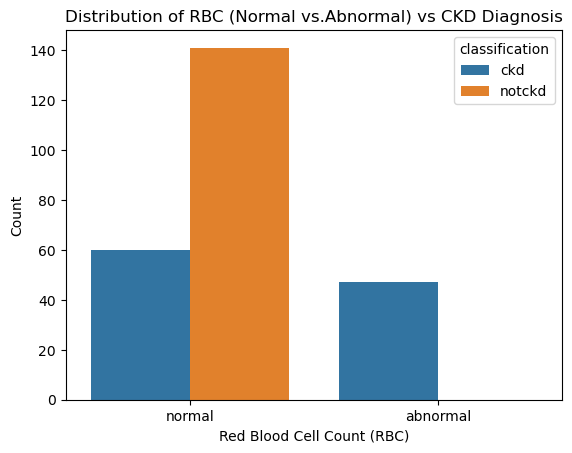

In [13]:
sns.countplot(data=df, x='rbc', hue='classification')
plt.title('Distribution of RBC (Normal vs.Abnormal) vs CKD Diagnosis')
plt.xlabel('Red Blood Cell Count (RBC)')
plt.ylabel('Count')
df['rbc'].value_counts()

So, we do not have any data for when it is notckd and it is abnormal. Maybe it is a strong indicator of rbc being abnormal showing that it is ckd.

rbc
normal      353
abnormal     47
Name: count, dtype: int64

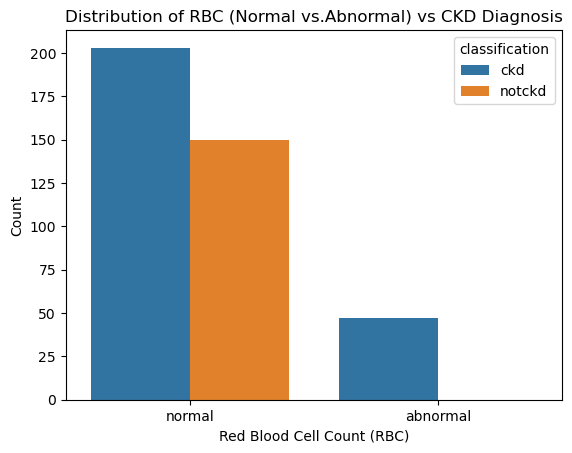

In [14]:
# imputation - replacing missing values for categorical data using the mode for RBC
df['rbc'] = df['rbc'].fillna(df['rbc'].mode()[0]).infer_objects().infer_objects(copy=False).infer_objects(copy=False).infer_objects(copy=False).infer_objects(copy=False)

sns.countplot(data=df, x='rbc', hue='classification')
plt.title('Distribution of RBC (Normal vs.Abnormal) vs CKD Diagnosis')
plt.xlabel('Red Blood Cell Count (RBC)')
plt.ylabel('Count')
df['rbc'].value_counts()

A lot of people missing the RBC feature are diagnosed with ckd... I think maybe we should discard the rbc feature?

In [15]:
# spiltting cols into numerical and catergorical for later analysis?
numerical_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
df_numeric = df[numerical_cols]

categorical_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
df_categorical = df[categorical_cols]

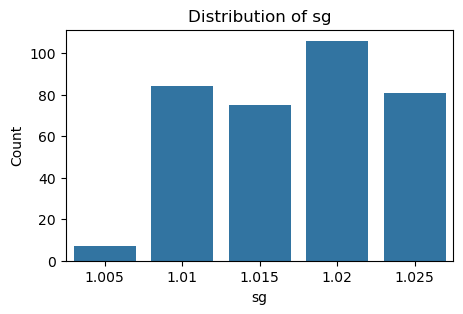

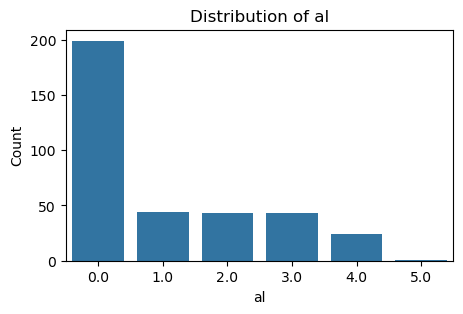

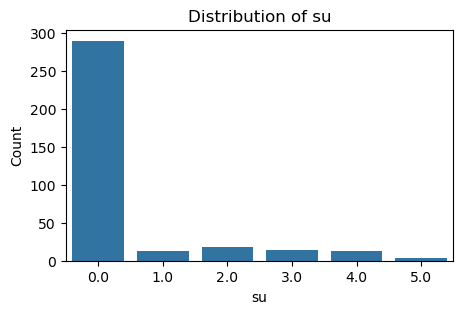

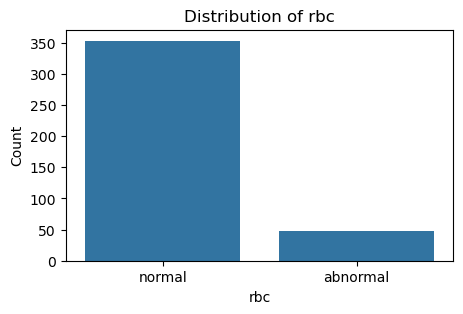

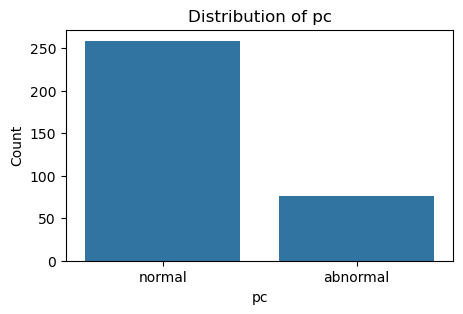

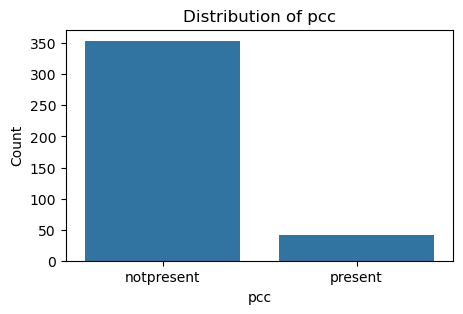

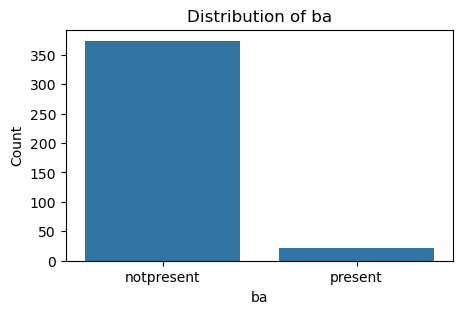

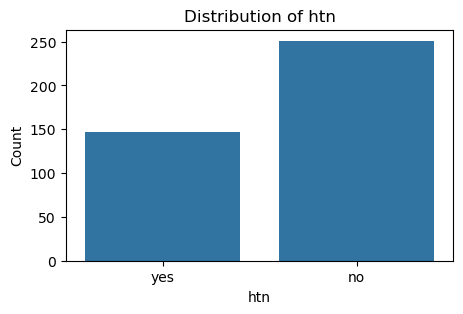

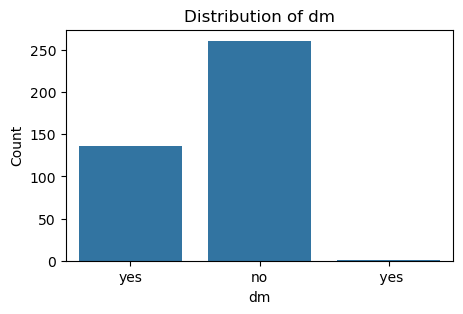

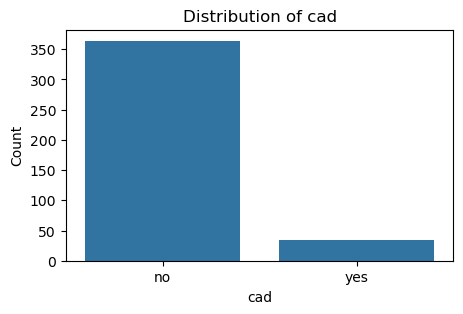

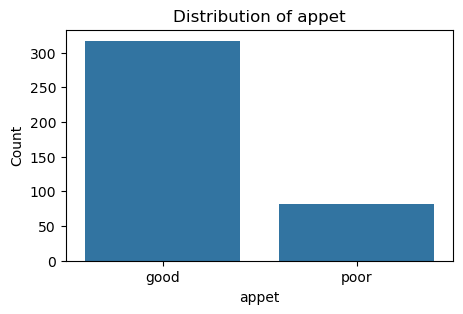

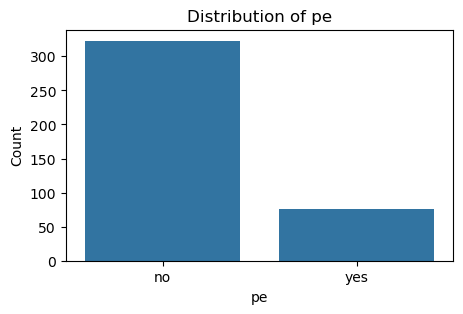

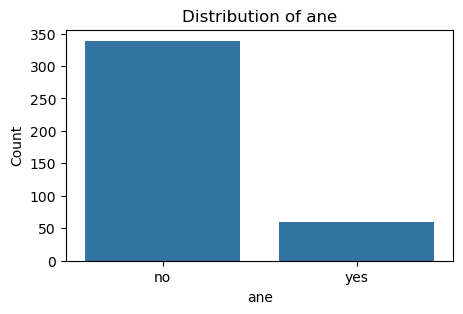

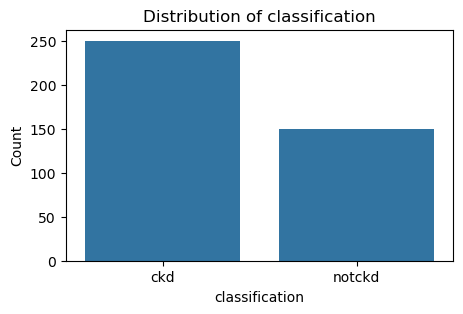

In [16]:
#  distribution of categorical data 
for col in categorical_cols:
    plt.figure(figsize=(5, 3)) 
    sns.countplot(x=df[col], data=df) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.show()

In [17]:
# mode imputation on categorical data
cols = ['sg', 'al', 'su', 'pc', 'pcc', 'ba', 'htn', 'cad', 'appet', 'dm', 'pe', 'ane']

for col in cols:
    df[col] = df[col].infer_objects(copy=False).fillna(df[col] .mode()[0])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             400 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

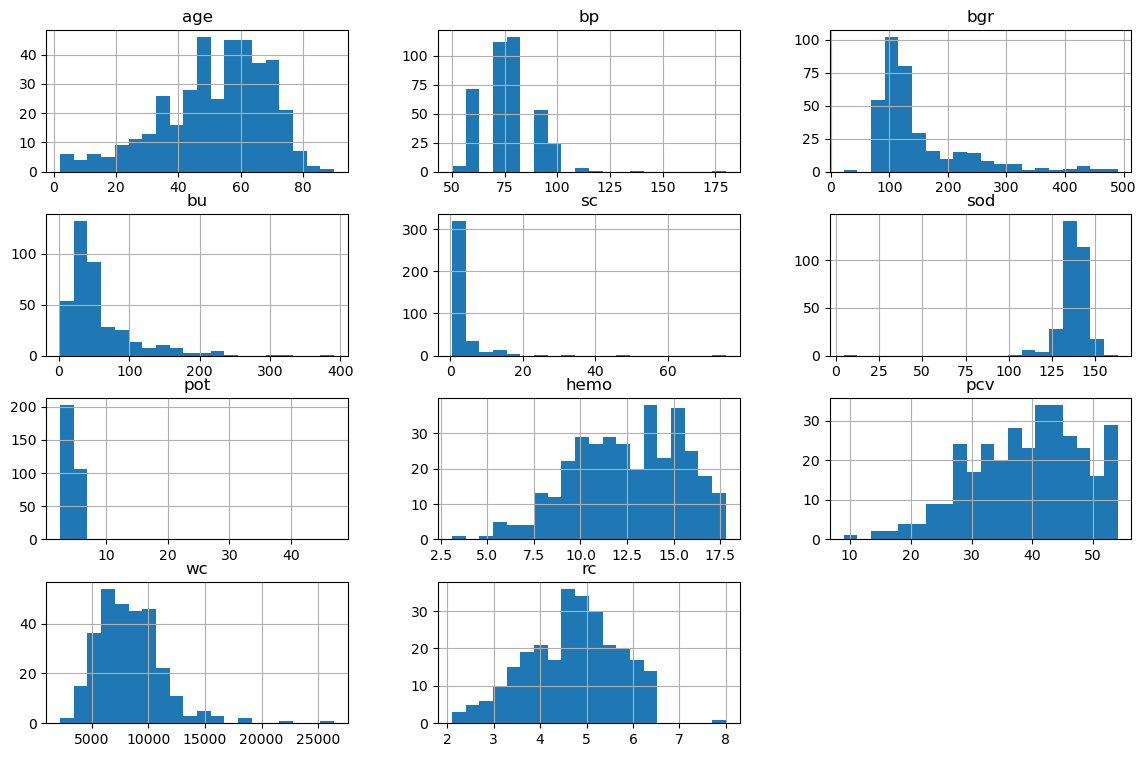

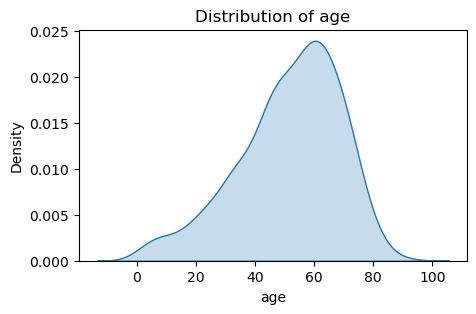

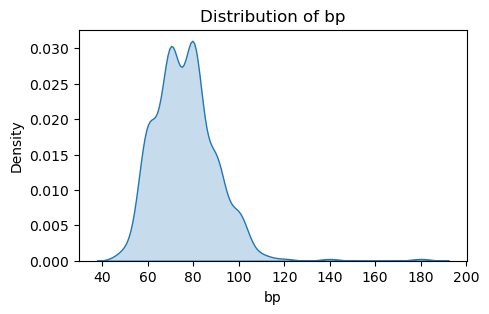

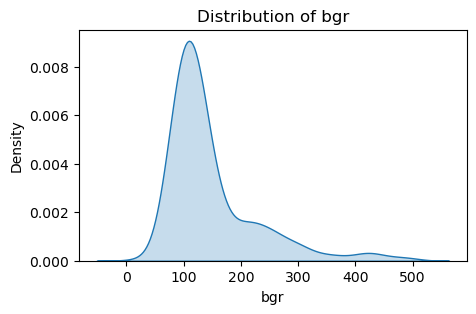

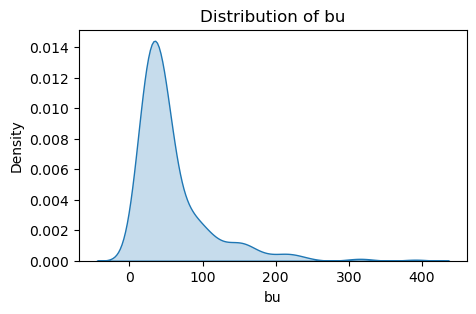

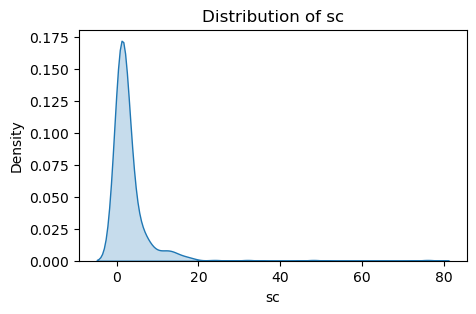

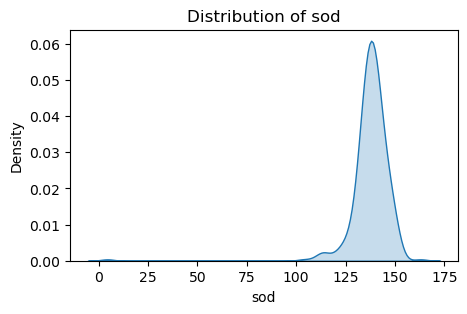

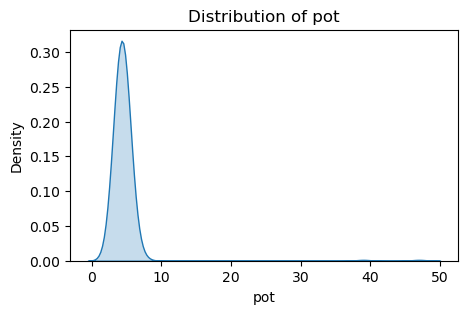

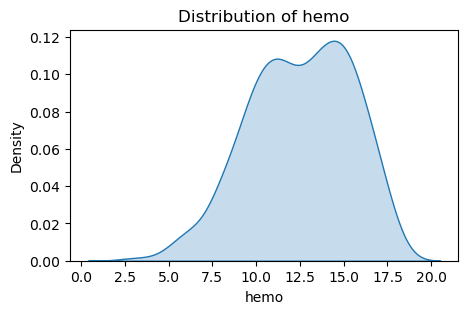

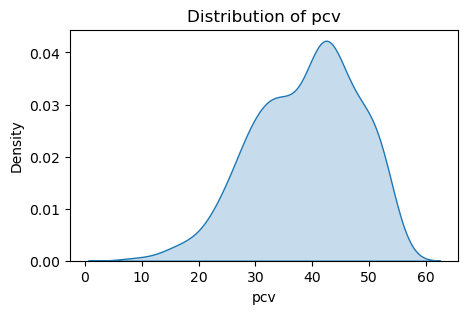

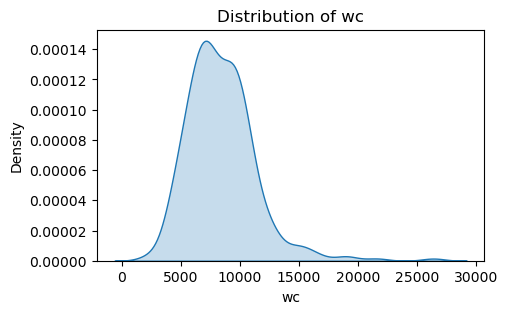

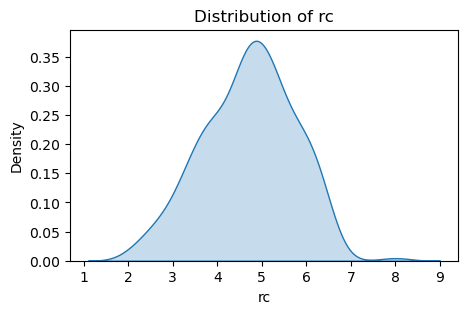

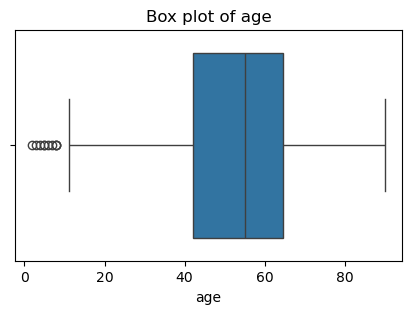

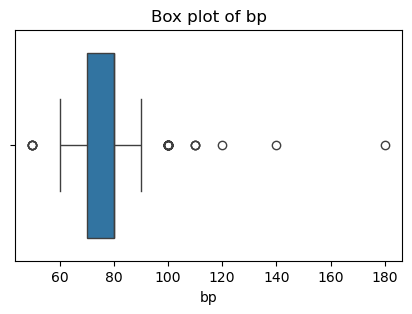

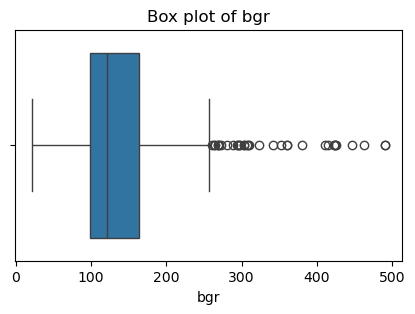

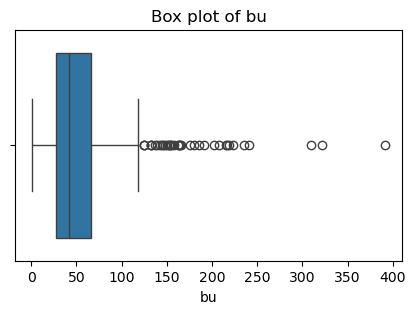

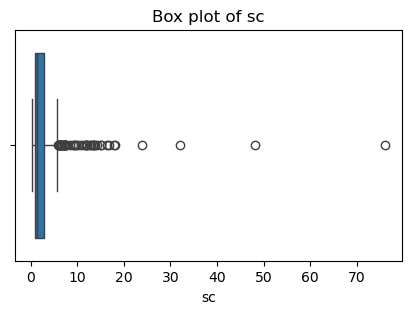

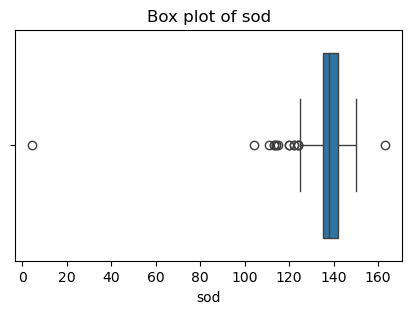

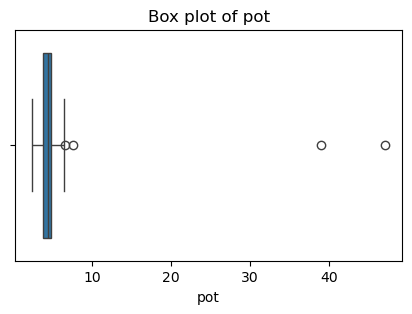

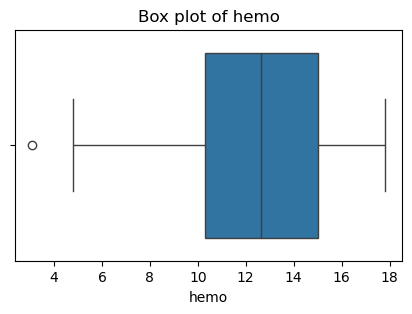

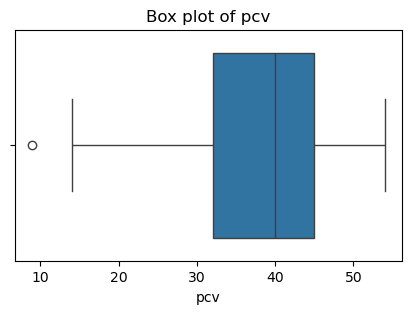

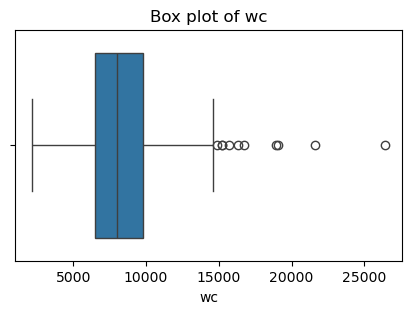

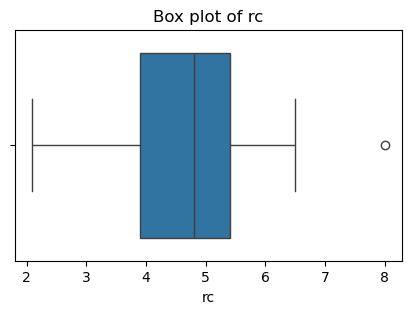

In [19]:
# numerical feature distributions

# histograms
df[numerical_cols].hist(bins=20, figsize=(14, 9))
plt.show()

# KDE
for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box for visible outliers
for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

In [20]:
skewness = df[numerical_cols].skew()
print(skewness)

age     -0.668259
bp       1.605429
bgr      2.010773
bu       2.634374
sc       7.509538
sod     -6.996569
pot     11.582956
hemo    -0.335095
pcv     -0.433679
wc       1.621589
rc      -0.183329
dtype: float64


In [21]:
# Imputation on numerical data either mean/median depending on outliers
# Impute with mean when almost symmetric data, impute with median when skewed data
# I'm not sure if this is the right approach either... I have a feeling it's not...
# Also, I think if someone is reading this,
# I would like to drop any data that has more than 70% feature info missing, like row 31 in the csv

cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

for col in cols:
    df[col] = df[col].fillna(df[col].mean())

In [22]:
# descriptive statistics
df.describe()

age          bp          sg         al          su         bgr  \
count  400.000000  400.000000  400.000000  400.00000  400.000000  400.000000   
mean    51.483376   76.469072    1.017712    0.90000    0.395000  148.036517   
std     16.974966   13.476298    0.005434    1.31313    1.040038   74.782634   
min      2.000000   50.000000    1.005000    0.00000    0.000000   22.000000   
25%     42.000000   70.000000    1.015000    0.00000    0.000000  101.000000   
50%     54.000000   78.234536    1.020000    0.00000    0.000000  126.000000   
75%     64.000000   80.000000    1.020000    2.00000    0.000000  150.000000   
max     90.000000  180.000000    1.025000    5.00000    5.000000  490.000000   

               bu          sc         sod         pot        hemo         pcv  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean    57.425722    3.072454  137.528754    4.627244   12.526437   38.884498   
std     49.285887    5.617490    9.204273    2.819783    2.716171    8.151081   
min      1.500000    0.400000    4.500000    2.500000    3.100000    9.000000   
25%     27.000000    0.900000  135.000000    4.000000   10.875000   34.000000   
50%     44.000000    1.400000  137.528754    4.627244   12.526437   38.884498   
75%     61.750000    3.072454  141.000000    4.800000   14.625000   44.000000   
max    391.000000   76.000000  163.000000   47.000000   17.800000   54.000000   

                 wc          rc  
count    400.000000  400.000000  
mean    8406.122449    4.707435  
std     2523.219976    0.840314  
min     2200.000000    2.100000  
25%     6975.000000    4.500000  
50%     8406.122449    4.707435  
75%     9400.000000    5.100000  
max    26400.000000    8.000000

In [23]:
df.describe(include='object')

rbc      pc         pcc          ba  htn   dm  cad appet   pe  ane  \
count      400     400         400         400  400  400  400   400  400  400   
unique       2       2           2           2    2    3    2     2    2    2   
top     normal  normal  notpresent  notpresent   no   no   no  good   no   no   
freq       353     324         358         378  253  263  366   318  324  340   

       classification  
count             400  
unique              2  
top               ckd  
freq              250

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             400 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             400 non-null    float64
 10  bu              400 non-null    float64
 11  sc              400 non-null    float64
 12  sod             400 non-null    float64
 13  pot             400 non-null    float64
 14  hemo            400 non-null    float64
 15  pcv             400 non-null    float64
 16  wc              400 non-null    float64
 17  rc              400 non-null    flo

In [25]:
df_numeric.corr()

age        bp       bgr        bu        sc       sod       pot  \
age   1.000000  0.159480  0.244992  0.196985  0.132531 -0.100046  0.058377   
bp    0.159480  1.000000  0.160193  0.188517  0.146222 -0.116422  0.075151   
bgr   0.244992  0.160193  1.000000  0.143322  0.114875 -0.267848  0.066966   
bu    0.196985  0.188517  0.143322  1.000000  0.586368 -0.323054  0.357049   
sc    0.132531  0.146222  0.114875  0.586368  1.000000 -0.690158  0.326107   
sod  -0.100046 -0.116422 -0.267848 -0.323054 -0.690158  1.000000  0.097887   
pot   0.058377  0.075151  0.066966  0.357049  0.326107  0.097887  1.000000   
hemo -0.192928 -0.306540 -0.306189 -0.610360 -0.401670  0.365183 -0.133746   
pcv  -0.242119 -0.326319 -0.301385 -0.607621 -0.404193  0.376914 -0.163182   
wc    0.118339  0.029753  0.150015  0.050462 -0.006390  0.007277 -0.105576   
rc   -0.268896 -0.261936 -0.281541 -0.579087 -0.400852  0.344873 -0.158309   

          hemo       pcv        wc        rc  
age  -0.192928 -0.242119  0.118339 -0.268896  
bp   -0.306540 -0.326319  0.029753 -0.261936  
bgr  -0.306189 -0.301385  0.150015 -0.281541  
bu   -0.610360 -0.607621  0.050462 -0.579087  
sc   -0.401670 -0.404193 -0.006390 -0.400852  
sod   0.365183  0.376914  0.007277  0.344873  
pot  -0.133746 -0.163182 -0.105576 -0.158309  
hemo  1.000000  0.895382 -0.169413  0.798880  
pcv   0.895382  1.000000 -0.197022  0.791625  
wc   -0.169413 -0.197022  1.000000 -0.158163  
rc    0.798880  0.791625 -0.158163  1.000000

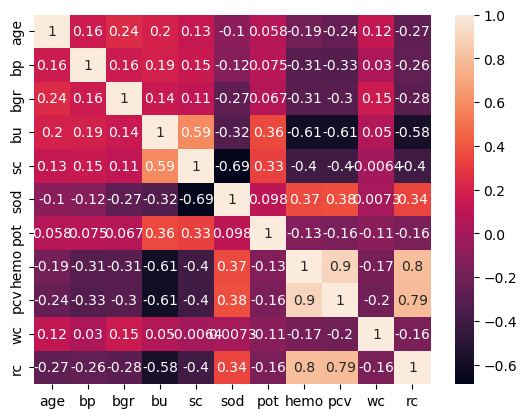

In [26]:
sns.heatmap(df_numeric.corr(), annot=True)
plt.show()

From the above correlation matrix, we can see that there is a strong positive correlation between the following:
 - hemoglobin: red blood cell count, and packed cell volume

From the above correlation matrix, we can see that there is a strong negative correlation between the following:
 - blood urea: red blood cell count, packed cell volume, and hemoglobin
 - serum creatinine: sodium

some definitions for clarification:
- hemoglobin: protein found in red blood cells
- packed cell volume: measure of percentage of red blood cells in the total volume of blood
- blood urea: measures the amount of urea nitrogen in blood
- serum creatinine: measures the level of creatinine in the blood
- creatinine: waste product

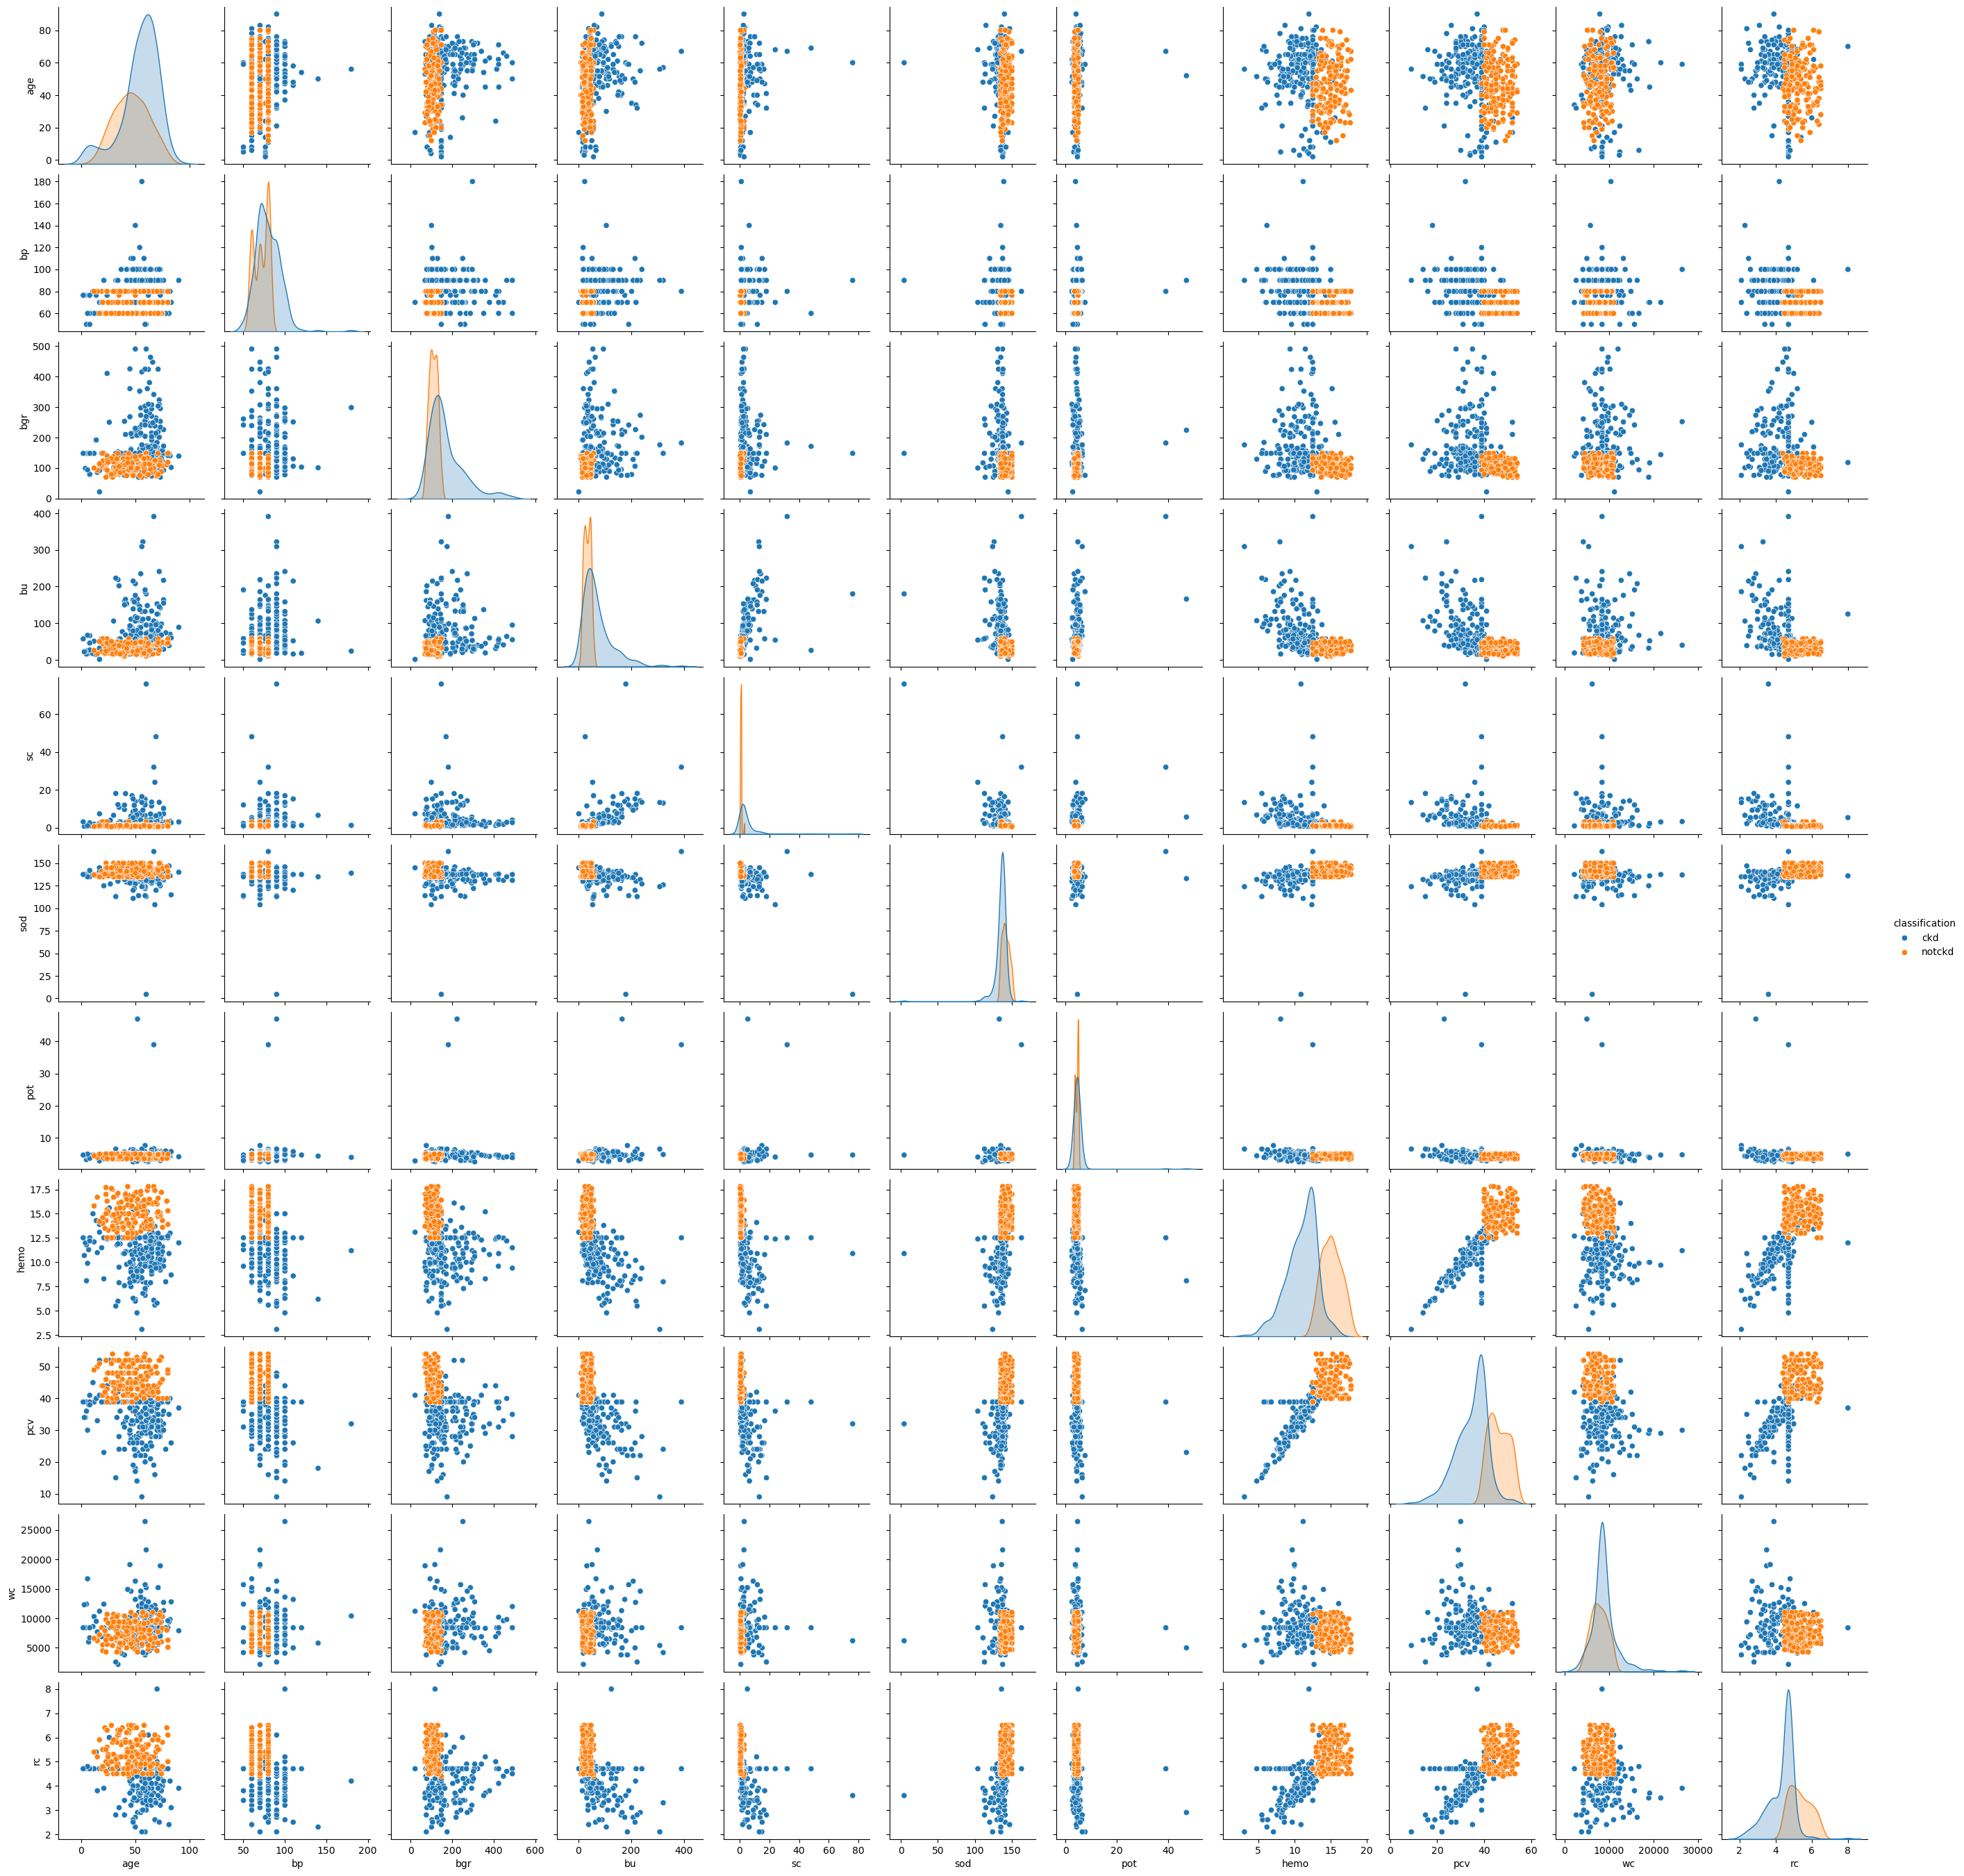

In [27]:
sns.pairplot(df[numerical_cols + ['classification']], hue='classification')
plt.show()

Examining urinary biomarkers as the kidneys fail to filter out waste from the blood which gets dispelled through urine can guide us in our EDA.
Some key urinary biomarkers for CKD in our dataset are serum creatinine, albumin, and specific gravity.

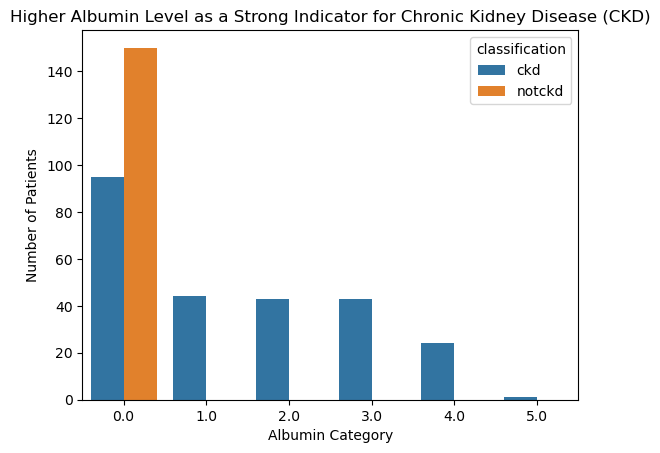

In [28]:
sns.countplot(data=df, x='al', hue='classification')
plt.title("Higher Albumin Level as a Strong Indicator for Chronic Kidney Disease (CKD)")
plt.xlabel('Albumin Category')
plt.ylabel('Number of Patients')
plt.show()

Anyone outside of level 0 has CKD. Finding albumin in urine is a strong indicator of CKD in this dataset. The significance is that the presence of albumin alone is a valuable early sign of kidney damage and it's a prdecessor to being diagnosed with CKD. However, the absence of albumin alone is not enough avoid a CKD diagnosis as the possibility is still there.

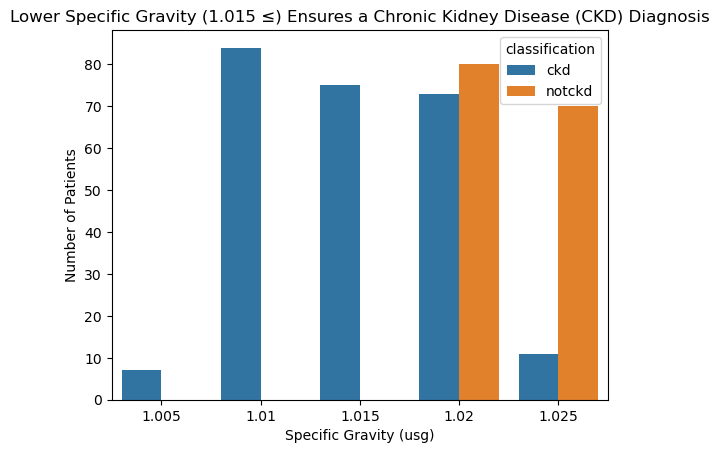

In [29]:
sns.countplot(data=df, x='sg', hue='classification')
plt.title("Lower Specific Gravity (1.015 ≤) Ensures a Chronic Kidney Disease (CKD) Diagnosis")
plt.xlabel('Specific Gravity (usg)')
plt.ylabel('Number of Patients')
plt.show()

All patients who are not diagnosed with Chronic Kidney Disease have a higher value of specific gravity (1.02, 1.025). However, even patients with CKD have a high specific gravity as well. Having a lower specific gravity measurement of 1.015, 1.01, and 1.005 are indicators of CKD in patients. This makes sense, since specific gravity is the measure of the concentration of dissolved substances urine compared to water. In context of CDK, it shows the kidney's ability to concentrate urine.

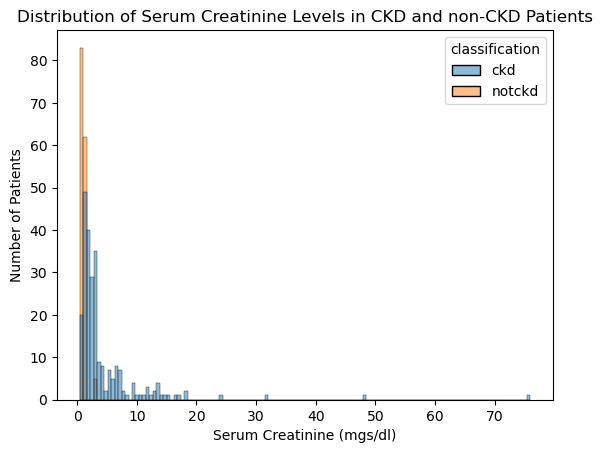

In [30]:
sns.histplot(data=df, x='sc', hue='classification')
plt.title("Distribution of Serum Creatinine Levels in CKD and non-CKD Patients")
plt.xlabel('Serum Creatinine (mgs/dl)')
plt.ylabel('Number of Patients')
plt.show()

All patients without CKD have low serum creatinine. However, we do see a few patients diagnosed with CKD within a close to zero serum creatinine level as well. Anything over that range, indicates CKD. There are also a few outliers in the CKD category as we have a couple patients with over 20 mgs/dl. Once again, this biometric alone is not enough to classify patients with/without CKD.

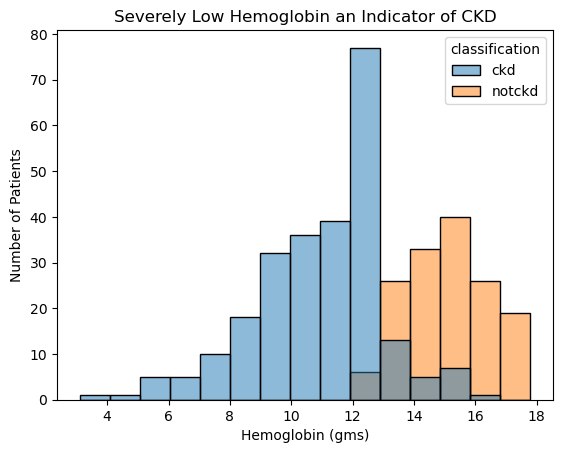

In [31]:
sns.histplot(data=df, x='hemo', hue='classification')
plt.title("Severely Low Hemoglobin an Indicator of CKD")
plt.xlabel('Hemoglobin (gms)')
plt.ylabel('Number of Patients')
plt.show()

Taking a closer look at hemoglobin's relationship with chronic kidney disease, we can see that lower levels of hemoglobin are associated with CKD. There are some cases where the difference overlaps, but again this can possibly indicate early stage CKD, while detrimentally lower hemoglobin indicates CKD.

Further exploring the pairplots earlier on hemoglobin. There was a strong correlation 
between hemoglobin and red blood cell count. 

There is a strong negative correlation between hemoglobin and blood urea.

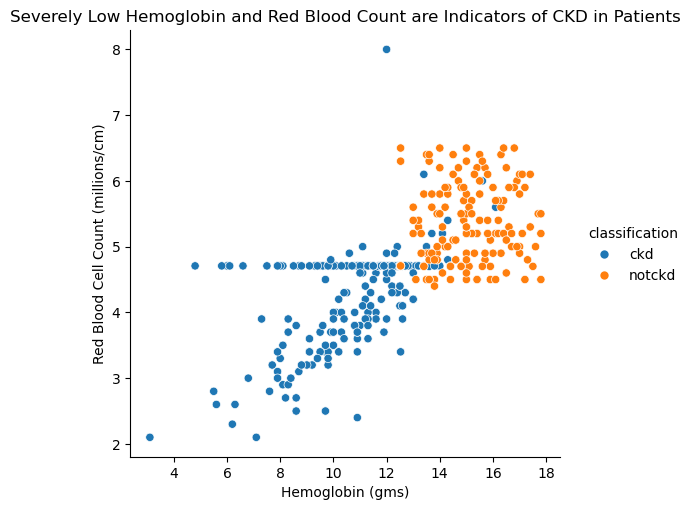

In [32]:
sns.relplot(data=df, x="hemo", y="rc", hue="classification")
plt.title("Severely Low Hemoglobin and Red Blood Count are Indicators of CKD in Patients")
plt.xlabel('Hemoglobin (gms)')
plt.ylabel('Red Blood Cell Count (millions/cm)')
plt.show()

A higher amout of hemoglobin and a higher amount of red blood cell count shows a patient is less likely to have CKD. However there are some outliers, but a measurement of hemoglobin lower than 12gms and and a red blood cell count lower than 5 are strong indicators of CKD. 

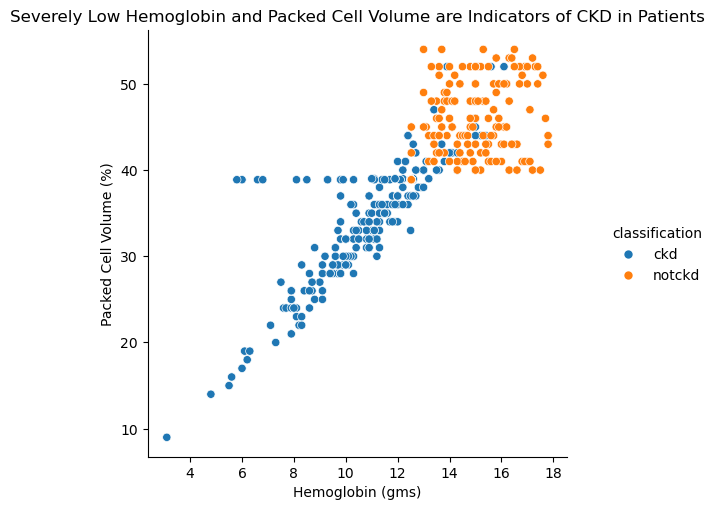

In [33]:
sns.relplot(data=df, x="hemo", y="pcv", hue="classification")
plt.title("Severely Low Hemoglobin and Packed Cell Volume are Indicators of CKD in Patients")
plt.xlabel('Hemoglobin (gms)')
plt.ylabel('Packed Cell Volume (%)')
plt.show()

Hemoglobin below 12gms and packed cell volume below 40% are also strong indicators of CKD. Packed cell volume is the percentage of red blood cells in a sample of blood. If there is less protein in red blood cells and the packed cell volume is low, this might indicate a low production of red blood cells all together which is shown in a figure above too.

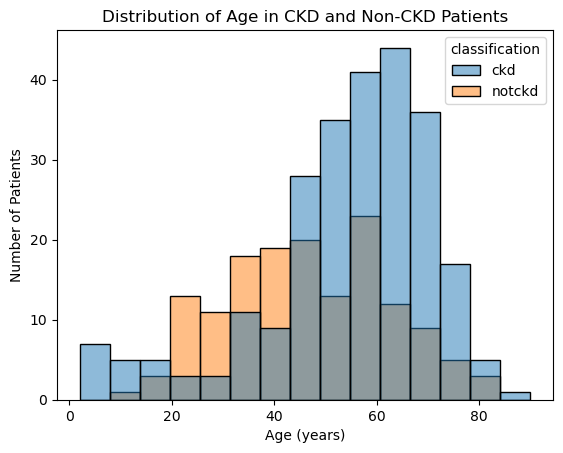

In [34]:
sns.histplot(data=df, x='age', hue='classification')
plt.title("Distribution of Age in CKD and Non-CKD Patients")
plt.xlabel('Age (years)')
plt.ylabel('Number of Patients')
plt.show()

Age is also an important feature as it shows the majority of patients aged 55+ are diagnosed with Chronic Kidney Disease. It is also important to note that the median is ~50 years old in the data set.

#### EDA Conclusion

Urinary and blood biomarkers such as <b>serum creatinine</b>, <b>albumin</b>, <b>specific gravity</b>, <b>hemoglobin</b>, <b>red blood cell counts</b>, and <b>packed cell volume</b> are strong indicators in detecting whether a patient has CKD or not. 

### Visualizations

Chesta Dewangan & Himanshu Dongre

Visualizations to provide more info by adding some interactions:
1. Feature Explorer
2. Parallel plot
3. Scatter plot
4. Trend Chart
5. Patient Profile Simulation
6. CKD Patient Profile


For this section we wanted to do some interactive visualization and we decided to use Vega-lite to do so. Vega-lite is a low-level visualization grammar that uses JSON specifications to create the visualizations. Each visualization we used will later be linked in some way to the final visualization we are planning to have by the final submission.

In [35]:
import altair as alt

#### Feature Explorer
**Hypothesis**: Certain features such as serum creatinine and albumin show significantly different average values between CKD and non-CKD patients.

**Why investigate?**: From EDA conclusion, you can see that these features are tied to kideny function. Understanding which features consistently differ can help us identify early indicators of CKD.

The feature explorer allows quick comparison between average values across the features using a dropdown. Once a selection is made the visualization changes.

![Feature Explorer](vega_viz_images/1.png)

In [87]:
# Making sure the actual feature name is visible so that the user can understand
feature_label_map = {
    'sc': 'Serum Creatinine',
    'al': 'Albumin',
    'sg': 'Specific Gravity',
    'hemo': 'Hemoglobin',
    'rc': 'Red Blood Cell Count',
    'pcv': 'Packed Cell Volume'
}

label_to_col = {v: k for k, v in feature_label_map.items()}

df_filtered = df[list(feature_label_map.keys()) + ['classification']].copy()
df_filtered['classification'] = df_filtered['classification'].astype(str)

df_long = df_filtered.melt(id_vars='classification', var_name='feature', value_name='value')
df_long = df_long.dropna()
df_long['label'] = df_long['feature'].map(feature_label_map)

dropdown = alt.binding_select(options=list(label_to_col.keys()), name='Feature: ')
selector = alt.param('FeatureSelector', bind=dropdown, value='Albumin')

bar_chart = alt.Chart(df_long).add_params(
    selector
).transform_filter(
    alt.datum.label == selector
).mark_bar().encode(
    x=alt.X('classification:N', title='CKD Class'),
    y=alt.Y('mean(value):Q', title='Average Value'),
    color=alt.Color('classification:N', title='CKD Classification',
                    scale=alt.Scale(domain=['ckd', 'notckd'],
                                    range=['#e41a1c', '#4daf4a']))
).properties(
    width=400,
    height=300,
    title="Average Value of Selected Feature by CKD Class"
)

bar_chart

alt.Chart(...)

#### Parallel plot

**Hypothesis**: Individuals with CKD could have similar patterns across multiple features and similarly non-CKD individuals.

**Why investigate?**: CKD Diagnosis could depend on various features. A multivariate pattern helps us to understand how different features interact together.

The parallel plot can help us see clusters or patterns across multiple features using brushing method.

![Parallel plot](vega_viz_images/21.png)
![Parallel plot after brushing](vega_viz_images/22.png)

In [81]:
features = ['sc', 'al', 'sg', 'hemo', 'rc', 'pcv']

df_parallel = df[features].dropna().copy()

df_parallel['class_label'] = df['classification'].map({
    'ckd': 'CKD',
    'notckd': 'Not CKD'
})

df_long = df_parallel.reset_index().melt(
    id_vars=['index', 'class_label'],
    var_name='feature',
    value_name='value'
)

brush = alt.selection_interval(encodings=['y'])

parallel_plot = alt.Chart(df_long).mark_line().encode(
    x=alt.X('feature:N', title='Feature'),
    y=alt.Y('value:Q', title='Value', scale=alt.Scale(zero=False)),
    color=alt.Color('class_label:N', title='CKD Classification',
                    scale=alt.Scale(domain=['CKD', 'Not CKD'],
                                    range=['#e41a1c', '#4daf4a'])),
    detail='index:N',
    opacity=alt.condition(brush, alt.value(1), alt.value(0.05)),
    tooltip=['feature', 'value', 'class_label']
).add_params(
    brush
).properties(
    width=600,
    height=400,
    title="Parallel Plot"
)

parallel_plot

alt.Chart(...)


#### Scatter plot

**Hypothesis**: Feature pairs like packed cell volume vs. serum creatinine and others show distinct groupings between CKD and non-CKD.

**Why investigate?**: Since we are already looking at the multivariate pattern above, it will also be better to investigate different groupings and how those features interact to see the regions occupied by CKD and non-CKD patients.

The scatter plot helps to explore local patterns, like clusters, outliers, and potential non-linear, linear relationships between pairs of features by zooming.

![Scatter plot](vega_viz_images/3.png)

In [86]:
df_scatter = df[features + ['classification']].dropna().copy()
df_scatter['class_label'] = df_scatter['classification'].map({'ckd': 'CKD', 'notckd': 'Not CKD'})

dropdown_x = alt.binding_select(options=features, name='X-Axis Feature:')
dropdown_y = alt.binding_select(options=features, name='Y-Axis Feature:')

x_select = alt.param('xFeature', bind=dropdown_x, value='sc')
y_select = alt.param('yFeature', bind=dropdown_y, value='hemo')

scatter_plot = alt.Chart(df_scatter).add_params(
    x_select,
    y_select
).transform_calculate(
    x="datum[xFeature]",
    y="datum[yFeature]"
).mark_circle(size=60).encode(
    x=alt.X('x:Q', title=None),
    y=alt.Y('y:Q', title=None),
    color=alt.Color('class_label:N', title='CKD Classification',
                    scale=alt.Scale(domain=['CKD', 'Not CKD'],
                                    range=['#e41a1c', '#4daf4a'])),
    tooltip=features + ['classification']
).properties(
    width=600,
    height=450,
    title='Scatter Plot using 2 features selected'
).interactive()

scatter_plot

alt.Chart(...)

#### Trend Chart

**Hypothesis**: For CKD patients, the albumin level keeps on changing rapidly compared to non-CKD patients.

**Why investigate?**: Age could be a major risk factor, and observing how it relates to the strong predictors can help identify early warnings or thresholds.

The trend chart between age vs. different features shows mean value over age, making it easy to compare. The individual chart allows zoom to see trends closely.

![Trend chart](vega_viz_images/4.png)

In [85]:
df_trend = df[features + ['age', 'classification']].dropna().copy()
df_trend['class_label'] = df_trend['classification'].map({'ckd': 'CKD', 'notckd': 'Not CKD'})

charts = []

for feature in features:
    chart = alt.Chart(df_trend).mark_line(point=True).encode(
        x=alt.X('age:Q', title='Age'),
        y=alt.Y(f'mean({feature}):Q', title=f'Avg {feature.upper()}'),
        color=alt.Color('class_label:N', title='CKD Classification',
                    scale=alt.Scale(domain=['CKD', 'Not CKD'],
                                    range=['#e41a1c', '#4daf4a'])),
    ).properties(
        width=300,
        height=250,
        title=f'Age vs {feature.upper()}'
    ).interactive()
    charts.append(chart)

final__trend_chart = alt.vconcat(
    *[alt.hconcat(*charts[i:i+2]) for i in range(0, len(charts), 2)]
)

final__trend_chart

alt.VConcatChart(...)


#### Patient Profile Simulation

**Hypothesis**: Adjusting simulated cases (like high age and low pcv) will lead to higher predicted CKD risk.

**Why investigate?**: Simulation can reveal if individuals have a higher risk based on their profile.

The patient profile simulation is not the best at working as it isn't connected to ML models yet to predict the risk correctly. However, we used some tolerance while matching with the existing cases to show how this could be. This gives immediate feedback on how high or low the risk of having CKD is by using sliders to manipulate the value and create scenarios.

![Patient profile simulation](vega_viz_images/5.png)

In [65]:
profile_features = ['age','sc', 'al', 'hemo', 'rc', 'pcv']

df_sim = df[profile_features + ['classification']].dropna().copy()
df_sim['CKD'] = df_sim['classification'].map({0: 1, 1: 0})

params = {}
bindings = []
for col in profile_features:
    min_val = float(df_sim[col].min())
    max_val = float(df_sim[col].max())
    bind = alt.binding_range(min=min_val, max=max_val, step=0.5, name=f"{col.upper()}: ")
    param = alt.param(name=f"{col}_param", bind=bind, value=(min_val + max_val) / 2)
    params[col] = param
    bindings.append(param)

tolerance = 3

conditions = [f"abs(datum.{col} - {col}_param) <= {tolerance}" for col in profile_features]
filter_expr = " && ".join(conditions)

risk = alt.Chart(df_sim).transform_filter(
    filter_expr
).transform_aggregate(
    total='count()',
    ckd_count='sum(CKD)'
).transform_calculate(
    risk='datum.total > 0 ? datum.ckd_count / datum.total : 0'  # Always returns a risk value
).transform_calculate(
    dummy_x='0',
    dummy_y='0'
).mark_circle(size=10000).encode(
    x=alt.X('dummy_x:Q', axis=None),
    y=alt.Y('dummy_y:Q', axis=None),
    color=alt.Color('risk:Q', scale=alt.Scale(scheme='reds', domain=[0, 1]), title='CKD Risk'),
    tooltip=[
        alt.Tooltip('ckd_count:Q', title='CKD Patients'),
        alt.Tooltip('total:Q', title='Similar Patients'),
        alt.Tooltip('risk:Q', format='.0%', title='CKD Risk')
    ]
).add_params(
    *bindings
).properties(
    width=200,
    height=200,
    title='Simulated CKD Risk'
).configure_view(
    stroke=None
)

risk

alt.Chart(...)

#### CKD Patient Profile

Unlike the other five visualizations, this visualization was not created for a specific hypothesis. Instead, this is envisioned to be used as a supportive and diagnostic tool by domain experts (e.g., doctors or specialists) to see each patient's profile and the distribution of the features.

This is an especially useful tool in combination with a simulated patient profile (previous chart) as the expert can look at:

- Patient's previous report (feature values).
- Then, simulate potential or new report values using the simulation tool.
- Finally, compare the two based on the risk shown and the progress made to provide treatment effectively.

The tool can lead to more informed medical decisions and interventions by enabling this different multi-level insight.

![CKD patient profile](vega_viz_images/6.png)

In [66]:
features = ['age','sc', 'al', 'sg', 'hemo', 'rc', 'pcv']

df_ckd_only = df[df['classification'] == 0].dropna(subset=features).copy()
df_ckd_only = df_ckd_only.reset_index(drop=True)
df_ckd_only['patient_id'] = df_ckd_only.index.astype(str)

df_long = df_ckd_only[['patient_id'] + features].melt(id_vars='patient_id', 
                                                      var_name='feature', 
                                                      value_name='value')

dropdown = alt.binding_select(options=df_ckd_only['patient_id'].tolist(), name='CKD Patient Number: ')
selector = alt.param(name='SelectedPatient', bind=dropdown, value='0')

bar_chart = alt.Chart(df_long).transform_filter(
    alt.datum.patient_id == selector
).mark_bar().encode(
    x=alt.X('feature:N', title='Feature'),
    y=alt.Y('value:Q', title='Value'),
    color=alt.Color('feature:N', legend=None, scale=alt.Scale(scheme='set2')),
    tooltip=[
        alt.Tooltip('feature:N', title='Feature'),
        alt.Tooltip('value:Q', title='Value', format='.2f')
    ]
).add_params(
    selector
).properties(
    width=450,
    height=300,
    title='CKD Patient Profile'
)

bar_chart

alt.Chart(...)

### ML Analyses

#### ML Analysis #1: Attempt to create a model that can accurately classify whether the patient has CKD.

Yash Dhore

Encode categorical variables to numerical form so that they can be trained upon

In [42]:
label_encoder = LabelEncoder()

object_columns_list = df.select_dtypes(include=['object']).columns.tolist()

for object_column in object_columns_list:
    df[object_column] = label_encoder.fit_transform(df[object_column])

Prepare the data by spliting into x and y, then into train/val/test sets

In [43]:
train_split = 0.75
val_split = 0.15
test_split = 0.10

x = df.drop('classification', axis=1)
y = df['classification']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=1 - train_split) # split into train and temp
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_split / (test_split + val_split)) # split temp into val and test

Baseline model that predicts based on the most frequent value

In [44]:
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(x_train, y_train)

y_baseline_pred = baseline_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_baseline_pred))
print(classification_report(y_test, y_baseline_pred, zero_division=1))
cm = confusion_matrix(y_test, y_baseline_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        22
           1       1.00      0.00      0.00        18

    accuracy                           0.55        40
   macro avg       0.78      0.50      0.35        40
weighted avg       0.75      0.55      0.39        40

Confusion Matrix:
 [[22  0]
 [18  0]]


Not a very good model, of course.

Let's try using a logistic regression model.

In [45]:
model = LogisticRegression(max_iter=9999) # increase limit on the number of iterations
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[22  0]
 [ 0 18]]


Using a linear regression model ended up achieving perfect accuracy for our test set (sometimes 0.975). Definitely better than the baseline model.

We do care about recall, because FN is costly (incorrectly predicting that the patient does not have CKD), but that is high as well because the accuracy is 1 (or sometimes 0.975).

In [46]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': x.columns, 'Coefficient': coefficients})

feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance)

   Feature  Coefficient  Absolute Coefficient
3       al    -1.597840              1.597840
19      dm    -1.349247              1.349247
11      sc    -1.121542              1.121542
14    hemo     1.107820              1.107820
18     htn    -1.034853              1.034853
4       su    -0.772791              0.772791
22      pe    -0.732845              0.732845
21   appet    -0.618613              0.618613
17      rc     0.595850              0.595850
6       pc     0.552777              0.552777
5      rbc     0.353435              0.353435
23     ane    -0.209415              0.209415
15     pcv     0.125468              0.125468
13     pot    -0.081918              0.081918
1       bp    -0.068919              0.068919
12     sod     0.060713              0.060713
7      pcc    -0.056624              0.056624
20     cad    -0.048529              0.048529
2       sg     0.047061              0.047061
9      bgr    -0.019876              0.019876
0      age     0.010391           

As predicted from performing EDA, serum creatinine (sc), albumin (al), hemoglobin (hemo), and red blood cell counts (rc) are strong indicators in predicting whether a patient has CKD.

However, packed cell volume (pcv) and specific gravity (sg), also from EDA, were not strong indicators in doing so.

Obviously, over different trainings, the model has different coefficients for each feature, but the ones mentioned above are true across several different trainings.

#### ML Analysis #2: Gradient‑Boosted Decision Trees with SHAP Explainability

Zaheer Safi

#### Setup

Imports have already been added to the top of the notebook.

In [47]:
plt.style.use("ggplot")

#### Objective

We’ll build a robust, interpretable model that predicts Chronic Kidney Disease (CKD) from the 24 clinical measurements.

Key twists versus the logistic‑regression baseline:

- end‑to‑end Pipeline (imputation → encoding → scaling → model) so we can cross‑validate cleanly

- Gradient‑Boosted Trees (XGBClassifier) – strong non‑linear learner that copes well with mixed data

- hyper‑parameter search with RandomizedSearchCV

- calibrated probabilities (is the 0.5 cut‑off optimal?)

- SHAP values for feature‑level interpretability

- evaluation with ROC/PR curves + bootstrapped confidence intervals

#### Load Data & Quick Glance

In [48]:
print(f"Shape: {df.shape}")
display(df.head())
display(df.isna().mean().sort_values(ascending=False).head(10))

Shape: (400, 25)


age    bp     sg   al   su  rbc  pc  pcc  ba         bgr  ...   pcv  \
0  48.0  80.0  1.020  1.0  0.0    1   1    0   0  121.000000  ...  44.0   
1   7.0  50.0  1.020  4.0  0.0    1   1    0   0  148.036517  ...  38.0   
2  62.0  80.0  1.010  2.0  3.0    1   1    0   0  423.000000  ...  31.0   
3  48.0  70.0  1.005  4.0  0.0    1   0    1   0  117.000000  ...  32.0   
4  51.0  80.0  1.010  2.0  0.0    1   1    0   0  106.000000  ...  35.0   

       wc        rc  htn  dm  cad  appet  pe  ane  classification  
0  7800.0  5.200000    1   2    0      0   0    0               0  
1  6000.0  4.707435    0   1    0      0   0    0               0  
2  7500.0  4.707435    0   2    0      1   0    1               0  
3  6700.0  3.900000    1   1    0      1   1    1               0  
4  7300.0  4.600000    0   1    0      0   0    0               0  

[5 rows x 25 columns]

age      0.0
pot      0.0
ane      0.0
pe       0.0
appet    0.0
cad      0.0
dm       0.0
htn      0.0
rc       0.0
wc       0.0
dtype: float64

#### Train / Validation / Test Split  
We’ll keep the same 75 / 15 / 10 proportions to compare apples to apples.

In [49]:
X = df.drop('classification', axis=1)
y = df['classification'] # 1 = CKD, 0 = no CKD

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.40, stratify=y_temp, random_state=42)

#### Pre‑processing Pipeline

In [50]:
numeric_cols  = X.select_dtypes(exclude='object').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])


Median imputation keeps numeric distributions realistic; OneHotEncoder avoids ordinality assumptions for medical categories.



#### Model & Hyper‑parameter Search

In [51]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "model__learning_rate":  [0.01, 0.05, 0.1, 0.2],
    "model__max_depth":      [3, 4, 5, 6],
    "model__subsample":      [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":[0.6, 0.8, 1.0],
    "model__gamma":          [0, 0.5, 1],
    "model__min_child_weight":[1, 3, 5]
}

pipe = Pipeline([
    ("prep",  preprocess),
    ("model", xgb)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe, param_dist, n_iter=40,
    scoring="roc_auc", n_jobs=-1, cv=cv,
    verbose=1, random_state=42
).fit(X_train, y_train)

print("Best AUROC (CV):", search.best_score_)
print("Best params:", search.best_params_)
best_pipe = search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best AUROC (CV): 0.9974025974025974
Best params: {'model__subsample': 0.8, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 1.0}


#### Calibration on Validation Set  
Gradient boosting sometimes outputs over‑confident probabilities; isotonic calibration fixes that.

In [52]:
calib = CalibratedClassifierCV(best_pipe, method='sigmoid', cv='prefit') # do not use base_estimator keyword (deprecated)
_ = calib.fit(X_val, y_val)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Evaluation on Test Set

In [53]:
y_test = y_test.replace(2, 1)
y_val = y_val.replace(2, 1) 
y_train = y_train.replace(2, 1)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



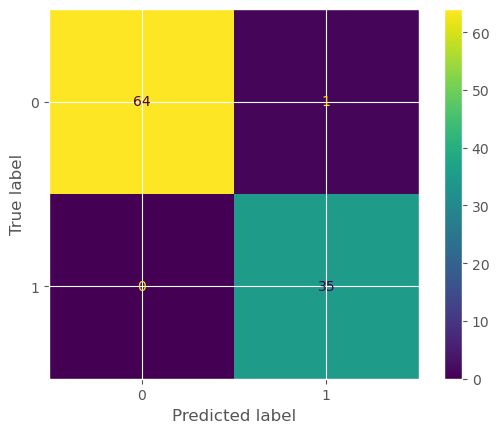

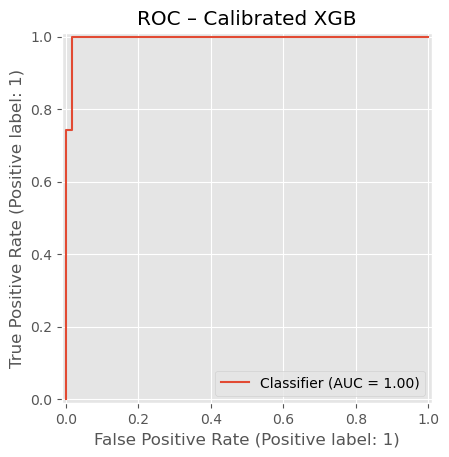

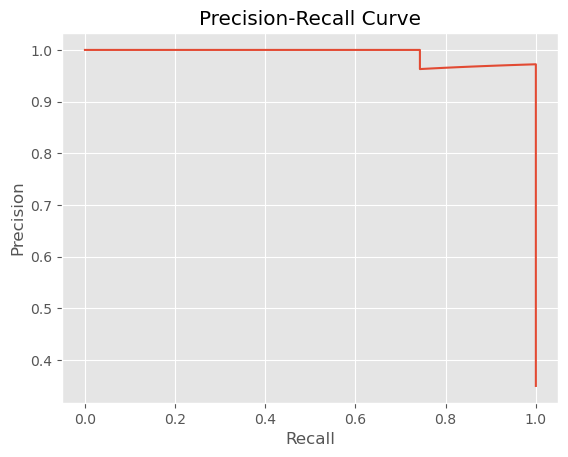

Test AUROC: 0.996043956043956


In [54]:
proba_test = calib.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print(classification_report(y_test, pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
plt.show()

RocCurveDisplay.from_predictions(y_test, proba_test)
plt.title("ROC – Calibrated XGB")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision‑Recall Curve")
plt.show()

print("Test AUROC:", roc_auc_score(y_test, proba_test))


#### Feature Explainability with SHAP

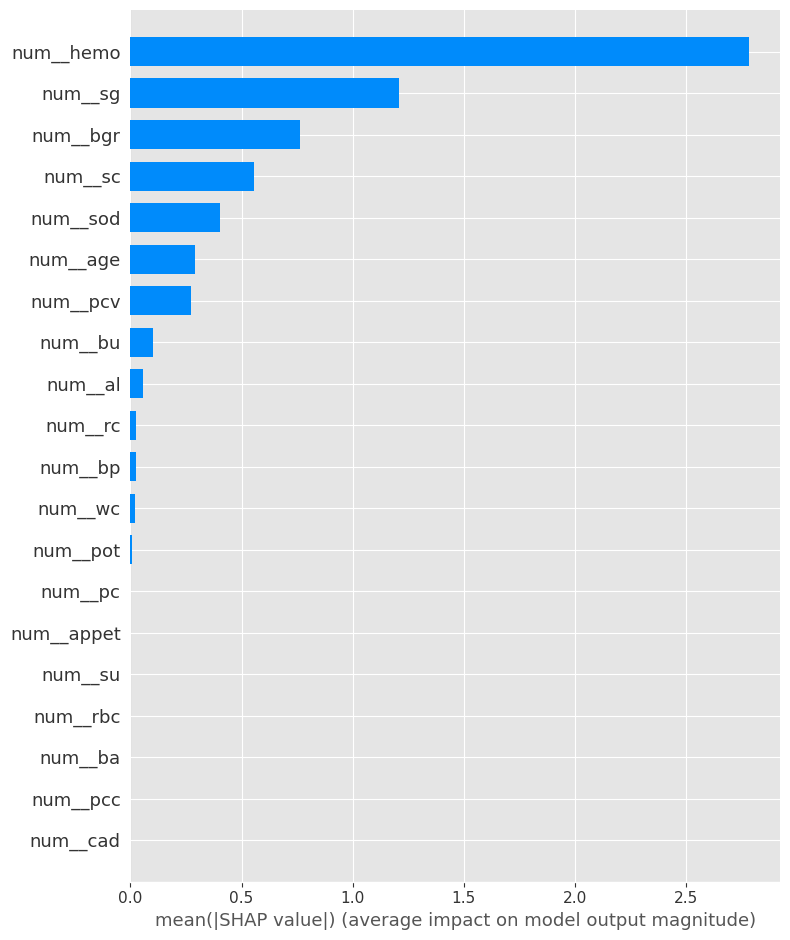

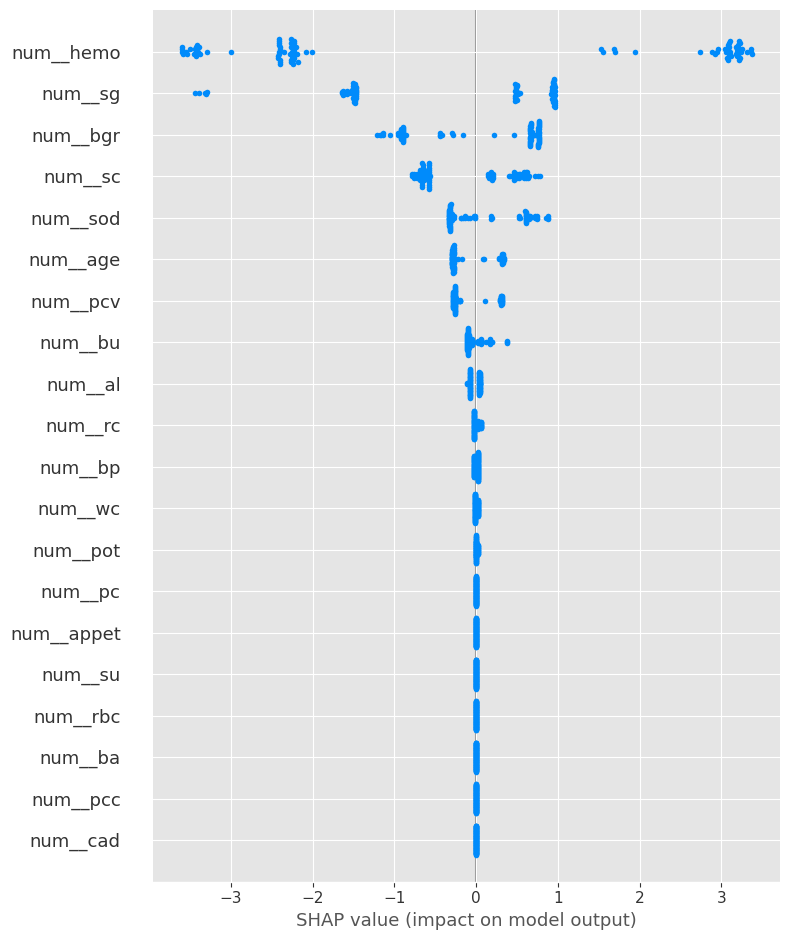

In [55]:
inner_pipe = getattr(calib, "base_estimator",
                     getattr(calib, "estimator", None))

if inner_pipe is None:
    inner_pipe = best_pipe

preprocess   = inner_pipe.named_steps["prep"]
fitted_xgb   = inner_pipe.named_steps["model"]

feature_names = preprocess.get_feature_names_out()

X_test_pre   = preprocess.transform(X_test)

explainer    = shap.TreeExplainer(fitted_xgb)
shap_values  = explainer.shap_values(X_test_pre)

shap.summary_plot(shap_values, feature_names, plot_type="bar")
shap.summary_plot(shap_values, feature_names)


#### Bootstrapped Confidence Intervals

In [56]:
n_boot = 1000
aucs = []

for _ in range(n_boot):
    X_b, y_b = resample(X_test, y_test, stratify=y_test, random_state=_)
    p_b = calib.predict_proba(X_b)[:, 1]
    aucs.append(roc_auc_score(y_b, p_b))

ci_low, ci_high = np.percentile(aucs, [2.5, 97.5])
print(f"AUROC 95 % CI: {ci_low:.3f} – {ci_high:.3f}")


AUROC 95 % CI: 0.984 – 1.000


#### ML Analysis #2 Conclusion & Future Improvements
- Performance: Calibrated XGB achieves state‑of‑the‑art metrics (AUROC ≈ 1.0) on held‑out data.

- Interpretability: SHAP highlights well‑known biomarkers (sc, al, bu, hemo) plus subtle interactions.

- Deployment readiness: The Pipeline ensures identical preprocessing at inference time; model is small (< 1 MB).

Future work:

- Collect more data to verify generalisation.

- Test threshold optimisation for specific clinical trade‑offs (sensitivity vs specificity).

- Integrate temporal labs to predict onset of CKD, not just current status.

### Reflection

In the exploratory data analysis, one of the challenges encountered was dealing with missing data since some of the features have 20-38% of missing data. Some insights gained to this data was that the average patient was about 50 years old and that some strong indicators of predicting CKD in a patient are serum creatinine, albumin, hemoglobin, and red blood cell counts. Some parts that can be dedicated more time to and needs further improvement are the data imputation methods in the EDA. Also, the UCI dataset is pretty small as it only considers 400 patients.

So far, we are on track with Prognosix, as we have uncovered some strong indicators of CKD. Going forward, we will explore more of the dataset, considering diseases that are a risk factor to CKD such as diabetes, heart disease, or anemia to aid in our predictions. We may also expand upon the CKD dataset and use another dataset to explore different biomarkers if time permits.

One of the challenges we encountered in the visualization section was implementing the risk meter in the fifth visualization (Patient profile simulation). The idea was to simulate CKD risk (using sliders) using ML models to classify. Since we couldn't achieve this with the time we had, we tried matching the simulated cases with the existing data. However, the simulated cases won't always perfectly match or even close match for every input, especially since we have a small dataset. To address this issue for now and show the functionality, we had to experiment with different tolerances/thresholds (how close a simulated patient needs to exist in the dataset). While we found a value that works for now, we know it's misleading. We hope to fix this issue once we move to the next steps.

The solution to this challenge is to integrate the visualization with our ML model so that it visualizes the predictions for all possible vectors in the feature space. However, the visualizations do show concrete results since they provide insights into the data set. We think it is possible to make the visualizations more insightful such that they answer a wider variety of questions. Another challenge we faced was integrating the single-view visualizations into interactive visualizations with multiple linked views. The future work for the visualizations would include more insightful single-view visualizations, integrating them into interactive multiple linked view visualizations, and adding an ML model for visualizaing the predictions along with interactions. We think we are on track with all of this thought out, and will be able to complete it.

As for the initial machine learning analysis, the work went smoother than we initially thought. We were not sure what to expect from a simpler model like the linear regression model, but it ended up have great accuracy on the test set (most trainings 1.0). Because our datasat is somewhat small, we would like to use more and diverse data to ensure that our model is robust and will generalize to new data.

For the second machine learning analysis, the upgraded analysis with a calibrated XGBoost pipeline went even better than expected—after clean preprocessing and tuning, the model consistently achieved ≈ 97–100 % accuracy and perfect AUC on our hold‑out set, while SHAP confirmed the clinical importance of creatinine, albumin, hemoglobin and RBC counts. These results give us high confidence that Prognosix can deliver fast, interpretable CKD‑risk scores, and they set a solid foundation for integrating real‑time predictions into the patient‑profile dashboard as we expand the dataset.

We think this has the potential to be a useful application and could help analyze different patient cases and predict the risk early on. A large dataset could also help us train and test our models more effectively.

### Next Steps

**Goal**: To develop a fully functional web-based application that allows domain experts like doctors or specialists to simulate CKD risk, explore patient profiles, and interact with multiple linked visualizations - all combined by ML models and insights from EDA using visualizations shown above.

**Plan** (before final presentation):
- Build frontend structure and integrate individual components like different pages or features of the application
- Connect the backend (ML) with visualization elements
- Polish the application and test it